In [1]:
import time
import pickle
import warnings
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
from collections import Counter
warnings.filterwarnings("ignore")

# Visualizations
import seaborn as sns
import matplotlib.pyplot as plt

# Sklearn
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import (train_test_split, GridSearchCV,
                                     StratifiedKFold)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (RandomForestClassifier,  
                              GradientBoostingClassifier)
from sklearn.model_selection import cross_validate
from sklearn.metrics import (ConfusionMatrixDisplay, precision_score, recall_score, accuracy_score, f1_score)

# Imblearn
from imblearn.pipeline import Pipeline, make_pipeline
from imblearn.over_sampling import (SMOTE, ADASYN, BorderlineSMOTE, SVMSMOTE, SMOTEN)
from imblearn.under_sampling import (TomekLinks, NearMiss, AllKNN,
                                     EditedNearestNeighbours, 
                                     RepeatedEditedNearestNeighbours,
                                    RandomUnderSampler) 
from imblearn.combine import SMOTETomek, SMOTEENN


import shap

In [2]:
attrition_data = pd.read_csv('contents/attrition_features_ohe.csv')
attrition_data.head()

,Attrition,EnvironmentSatisfaction,Gender,JobLevel,JobSatisfaction,MonthlyIncome,OverTime,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,BusinessTravel_1,BusinessTravel_2,BusinessTravel_3,Age_Profile_1,Age_Profile_2,Age_Profile_3,Age_Profile_4
0,1,2,0,2,4,5993,1,0,1,6,1,0,0,0,1,0,0
1,0,3,1,2,2,5130,0,3,3,10,0,1,0,0,0,1,0
2,1,4,1,1,3,2090,1,3,3,0,1,0,0,0,1,0,0
3,0,4,0,1,3,2909,1,3,3,8,0,1,0,0,1,0,0
4,0,1,1,1,2,3468,0,3,3,2,1,0,0,0,1,0,0


# Data Splitting

In [53]:
X = attrition_data.drop(['Attrition'], axis=1)
y = attrition_data['Attrition']

In [4]:
(X_train, X_test, y_train, y_test) = train_test_split(X, y, random_state=42, test_size=0.30, stratify=y)

In [5]:
X_train.head()

,EnvironmentSatisfaction,Gender,JobLevel,JobSatisfaction,MonthlyIncome,OverTime,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,BusinessTravel_1,BusinessTravel_2,BusinessTravel_3,Age_Profile_1,Age_Profile_2,Age_Profile_3,Age_Profile_4
853,3,1,1,1,2552,0,4,3,1,1,0,0,1,0,0,0
435,2,1,3,3,13610,1,2,4,7,1,0,0,0,1,0,0
587,4,0,2,3,3149,0,3,3,5,1,0,0,0,0,1,0
1170,4,1,1,4,2580,0,0,2,4,0,1,0,0,1,0,0
159,3,0,1,3,2231,0,3,3,4,0,1,0,0,1,0,0


In [7]:
def auto_ml(X, y, models_dict, scaler=None, cv=None, res_t=None):
    """Apply resampling for imbalanced data"""
    results = {} # for plots/viz results
    results2 = {} # table results

    # log start time
    total_start = time.time()

    for model_name, model in tqdm(models_dict.items()):
        
        ################# this portion can be edited ###############
        # accuracy scores
        train_scores = []
        val_scores = []

        # recall scores
        train_recall = []
        val_recall = []
        
        # precision scores
        train_prec = []
        val_prec = []
        
        #f1 scores
        train_f1 = []
        val_f1 = []

        ###########################################################

        for train_index, val_index in tqdm(cv.split(X, y)):

            X_train, X_val = X.iloc[train_index], X.iloc[val_index]
            y_train, y_val = y.iloc[train_index], y.iloc[val_index]

            # Apply scaling to standardize values
            if scaler is not None:
                X_train = scaler.fit_transform(X_train)
                X_val = scaler.transform(X_val)
            else: # else use raw data
                pass 

            # Apply resampling
            if res_t is not None:
                s = time.time()
                X_train, y_train = res_t.fit_resample(X_train, y_train)
                print(f'Resampling done in {time.time() - s}')
            else:
                pass

            start_time = time.time()

            # fit
            model.fit(X_train, y_train)

            # predict
            train_preds = model.predict(X_train)
            val_preds = model.predict(X_val)
            
            ################# this portion can be edited ###############

            # classification accuracy
            train_scores.append(model.score(X_train, y_train))
            val_scores.append(model.score(X_val, y_val))

            # recall
            train_recall.append(recall_score(y_train, train_preds))
            val_recall.append(recall_score(y_val, val_preds))
            
            # precision
            train_prec.append(precision_score(y_train, train_preds))
            val_prec.append(precision_score(y_val, val_preds))
            
            # f1
            train_f1.append(f1_score(y_train, train_preds))
            val_f1.append(f1_score(y_val, val_preds))
            
            end_time = time.time()

            results[model_name] = {
                'Train Accuracy': np.round(np.mean(train_scores) * 100, 2),
                'Val Accuracy': np.round(np.mean(val_scores) * 100, 2),
                'Train Recall': np.round(np.mean(train_recall) * 100, 2),
                'Val Recall': np.round(np.mean(val_recall) * 100, 2),
                'Train Precision': np.round(np.mean(train_prec) * 100, 2),
                'Val Precision': np.round(np.mean(val_prec) * 100, 2),
                'Train F1 Score': np.round(np.mean(train_f1) * 100, 2),
                'Val F1 Score': np.round(np.mean(val_f1) * 100, 2),
                'Run Time': end_time - start_time
            }

            results2[model_name] = {
                'Train Accuracy': '{:.2f}%'.format(np.round(np.mean(train_scores)*100, 2)),
                'Val Accuracy': '{:.2f}%'.format(np.round(np.mean(val_scores)*100, 2)),
                'Train Recall': '{:.2f}%'.format(np.round(np.mean(train_recall)*100, 2)),
                'Val Recall': '{:.2f}%'.format(np.round(np.mean(val_recall)*100, 2)),
                'Train Precision': '{:.2f}%'.format(np.round(np.mean(train_prec)*100, 2)),
                'Val Precision': '{:.2f}%'.format(np.round(np.mean(val_prec)*100, 2)),
                'Train F1 Score': '{:.2f}%'.format(np.round(np.mean(train_f1)*100, 2)),
                'Val F1 Score': '{:.2f}%'.format(np.round(np.mean(val_f1)*100, 2)),
                'Run Time': end_time - start_time
            }
            
            ###########################################################

    results = pd.DataFrame(results).T
    results2 = pd.DataFrame(results2).T
    return [results, results2]

In [8]:
# MODEL DICTIONARY
models_dict = {
    'GradientBoostingClassifier': GradientBoostingClassifier(random_state=143)
}

In [9]:
auto_run = auto_ml(X_train, y_train, models_dict, cv=StratifiedKFold(n_splits=5))

auto = auto_run[0]
auto_run[1] # table results

  0%|          | 0/1 [00:00<?, ?it/s]

0it [00:00, ?it/s]

,Run Time,Train Accuracy,Train F1 Score,Train Precision,Train Recall,Val Accuracy,Val F1 Score,Val Precision,Val Recall
GradientBoostingClassifier,0.067053,92.64%,71.05%,97.15%,56.02%,85.72%,39.27%,63.50%,28.95%


# Sampling techniques

### Random Undersampling

In [10]:
res_list = [('RandomUnderSampler', RandomUnderSampler())
           ]

outputs_u = []
for title, res in res_list:
    print((title).center(120, "-"))
    var = auto_ml(X_train, y_train, models_dict,
                  cv=StratifiedKFold(n_splits=5), res_t=res)
    outputs_u.append(var[0])
    display(var[1])

---------------------------------------------------RandomUnderSampler---------------------------------------------------


  0%|          | 0/1 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Resampling done in 0.002161264419555664
Resampling done in 0.0014977455139160156
Resampling done in 0.00144195556640625
Resampling done in 0.0014390945434570312
Resampling done in 0.0014736652374267578


,Run Time,Train Accuracy,Train F1 Score,Train Precision,Train Recall,Val Accuracy,Val F1 Score,Val Precision,Val Recall
GradientBoostingClassifier,0.033163,95.48%,95.39%,97.50%,93.37%,68.90%,40.26%,29.44%,64.49%


In [11]:
# Recall
ps_under = pd.DataFrame(index=models_dict.keys())
ps_under['NoResampling Val Recall'] = auto_run[0]['Val Recall']
ps_under['RandomUnderSampler Val Recall'] = outputs_u[0]['Val Recall']
ps_under

,NoResampling Val Recall,RandomUnderSampler Val Recall
GradientBoostingClassifier,28.95,64.49


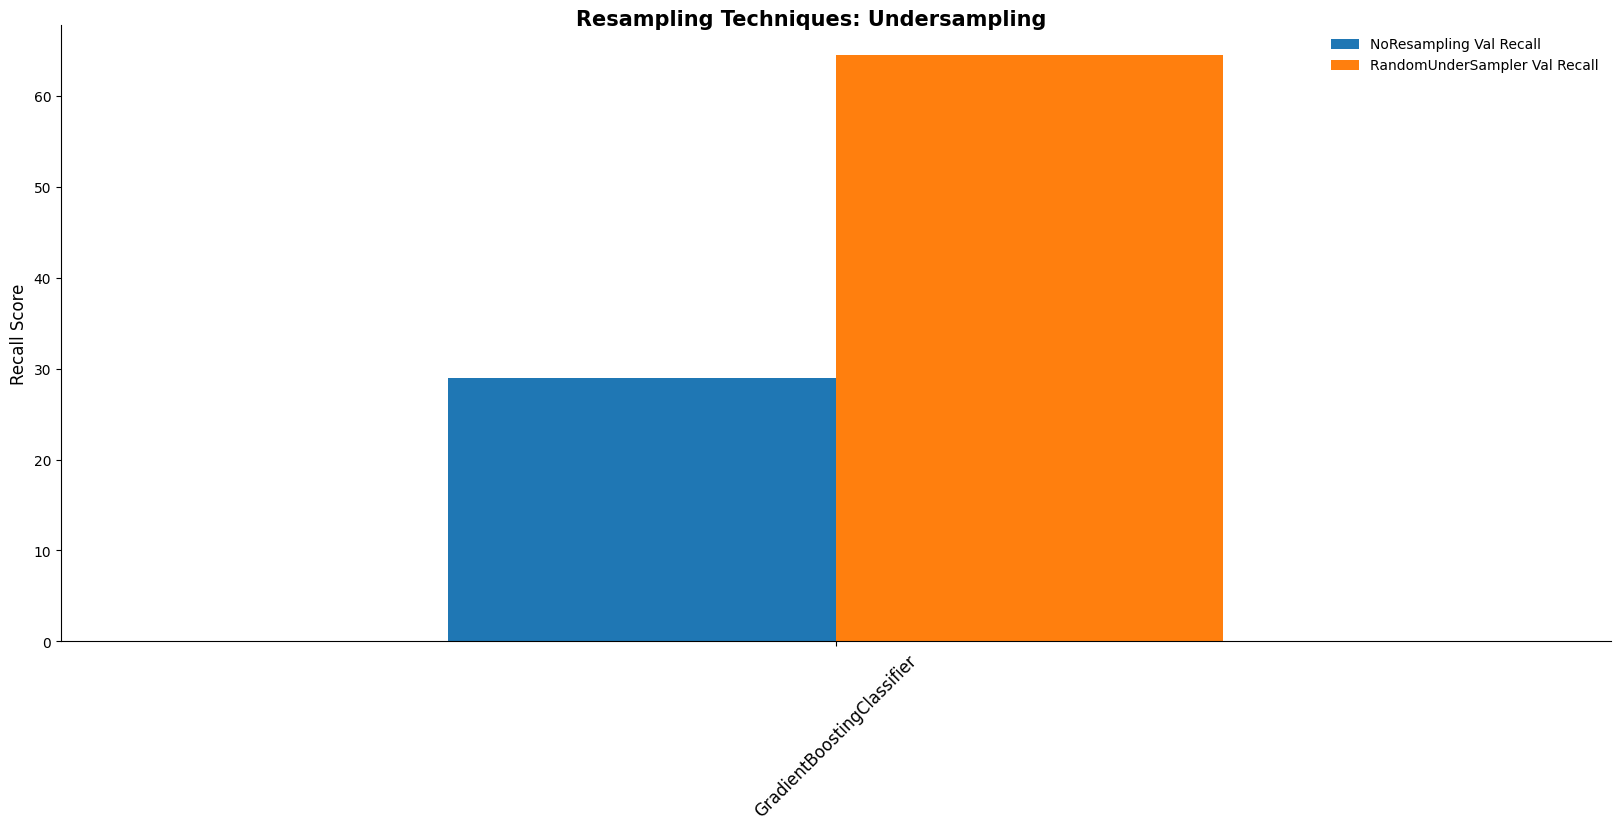

In [12]:
fig, ax = plt.subplots(figsize=(20, 8))
ps_under.plot.bar(ax=ax)
ax.set_ylabel('Recall Score', fontsize=12)
for spine in ['right', 'top']:
        ax.spines[spine].set_visible(False)
ax.legend(edgecolor='white')
fig.suptitle("Resampling Techniques: Undersampling", size=15, y=0.9, weight='bold')
plt.xticks(rotation=45, fontsize=12)
plt.show()

In [13]:
# Accuracy
ps_under_acc = pd.DataFrame(index=models_dict.keys())
ps_under_acc['NoResampling Val Accuracy'] = auto_run[0]['Val Accuracy']
ps_under_acc['RandomUnderSampler Val Accuracy'] = outputs_u[0]['Val Accuracy']
ps_under_acc

,NoResampling Val Accuracy,RandomUnderSampler Val Accuracy
GradientBoostingClassifier,85.72,68.9


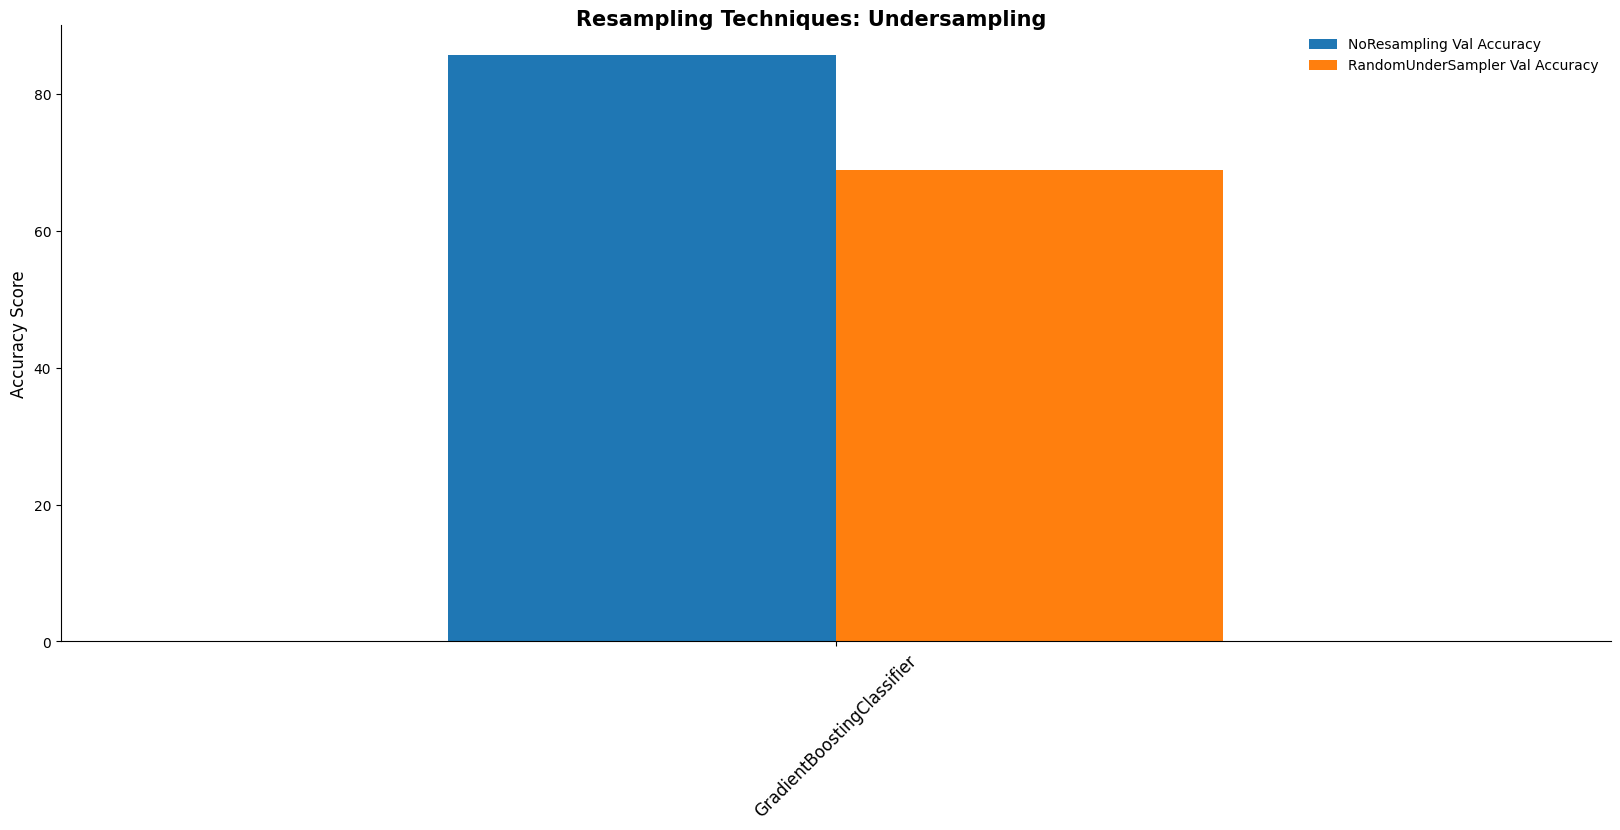

In [14]:
fig, ax = plt.subplots(figsize=(20, 8))
ps_under_acc.plot.bar(ax=ax)
ax.set_ylabel('Accuracy Score', fontsize=12)
for spine in ['right', 'top']:
        ax.spines[spine].set_visible(False)
ax.legend(edgecolor='white')
fig.suptitle("Resampling Techniques: Undersampling", size=15, y=0.9, weight='bold')
plt.xticks(rotation=45, fontsize=12)
plt.show()

In [15]:
# Accuracy
ps_under_acc = pd.DataFrame(index=models_dict.keys())
ps_under_acc['NoResampling Val Accuracy'] = auto_run[0]['Val Accuracy']
ps_under_acc['RandomUnderSampler Val Accuracy'] = outputs_u[0]['Val Accuracy']
ps_under_acc

,NoResampling Val Accuracy,RandomUnderSampler Val Accuracy
GradientBoostingClassifier,85.72,68.9


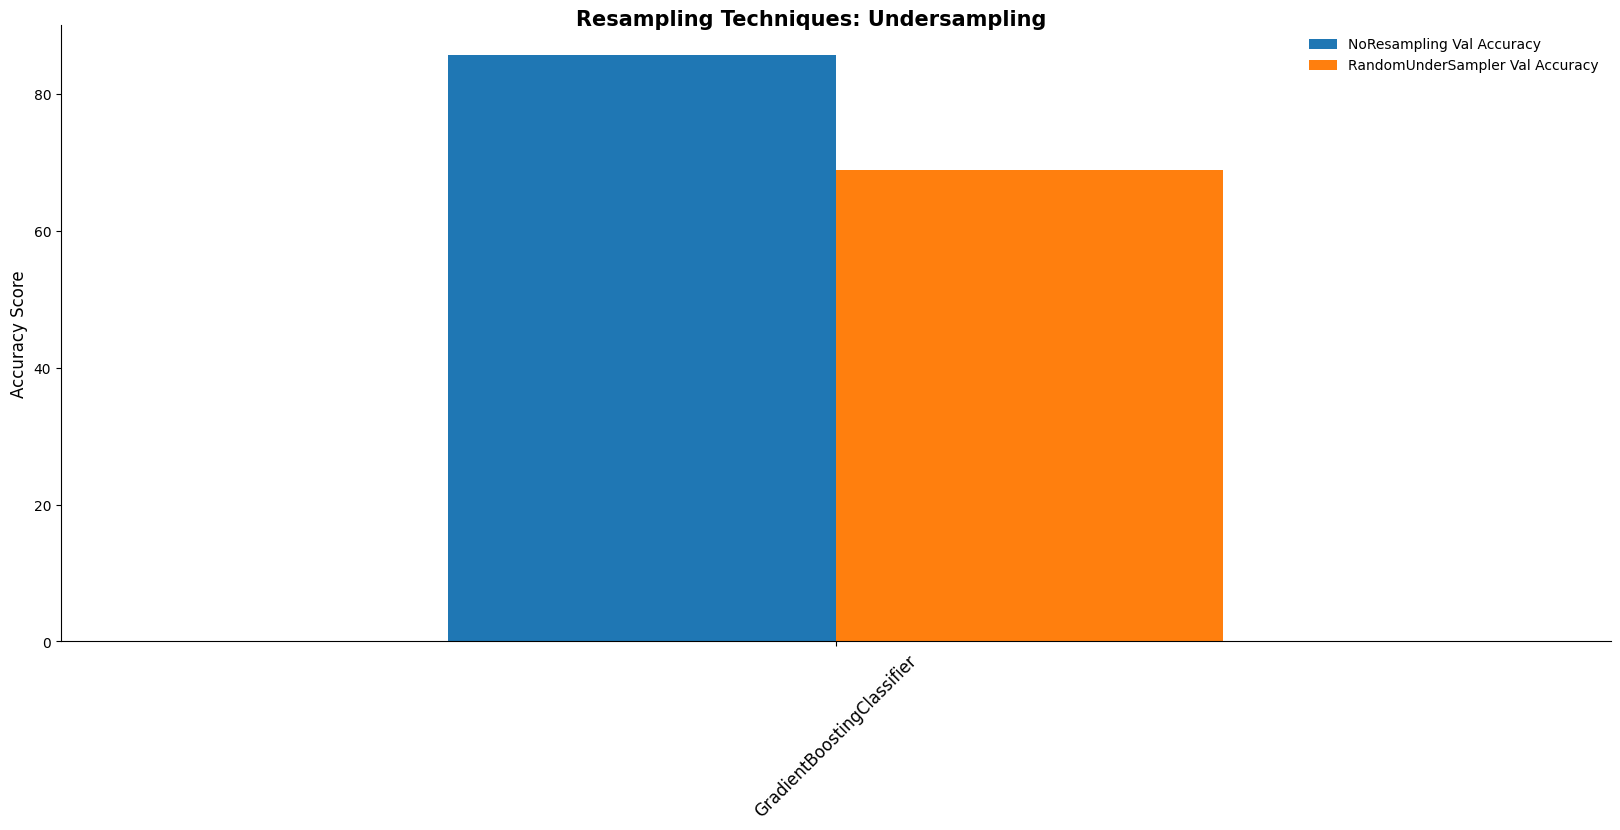

In [16]:
fig, ax = plt.subplots(figsize=(20, 8))
ps_under_acc.plot.bar(ax=ax)
ax.set_ylabel('Accuracy Score', fontsize=12)
for spine in ['right', 'top']:
        ax.spines[spine].set_visible(False)
ax.legend(edgecolor='white')
fig.suptitle("Resampling Techniques: Undersampling", size=15, y=0.9, weight='bold')
plt.xticks(rotation=45, fontsize=12)
plt.show()

## TomekLinks and NearMiss

In [17]:
res_list = [('TomekLinks', TomekLinks()),
            ('NearMiss', NearMiss())]

outputs_u = []
for title, res in res_list:
    print((title).center(120, "-"))
    var = auto_ml(X_train, y_train, models_dict,
                  cv=StratifiedKFold(n_splits=5), res_t=res)
    outputs_u.append(var[0])
    display(var[1])

-------------------------------------------------------TomekLinks-------------------------------------------------------


  0%|          | 0/1 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Resampling done in 0.018934011459350586
Resampling done in 0.011317014694213867
Resampling done in 0.011456012725830078
Resampling done in 0.021045207977294922
Resampling done in 0.011056900024414062


,Run Time,Train Accuracy,Train F1 Score,Train Precision,Train Recall,Val Accuracy,Val F1 Score,Val Precision,Val Recall
GradientBoostingClassifier,0.062705,92.75%,74.70%,95.99%,61.14%,85.81%,44.12%,59.78%,35.56%


--------------------------------------------------------NearMiss--------------------------------------------------------


  0%|          | 0/1 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Resampling done in 0.00825810432434082
Resampling done in 0.005423784255981445
Resampling done in 0.003955364227294922
Resampling done in 0.005573749542236328
Resampling done in 0.0037589073181152344


,Run Time,Train Accuracy,Train F1 Score,Train Precision,Train Recall,Val Accuracy,Val F1 Score,Val Precision,Val Recall
GradientBoostingClassifier,0.032364,97.66%,97.62%,99.38%,95.93%,38.97%,28.15%,17.39%,74.12%


In [18]:
# Recall
ps_under = pd.DataFrame(index=models_dict.keys())
ps_under['NoResampling Val Recall'] = auto_run[0]['Val Recall']
ps_under['TomekLinks Val Recall'] = outputs_u[0]['Val Recall']
ps_under['NearMiss Val Recall'] = outputs_u[1]['Val Recall']
ps_under

,NoResampling Val Recall,TomekLinks Val Recall,NearMiss Val Recall
GradientBoostingClassifier,28.95,35.56,74.12


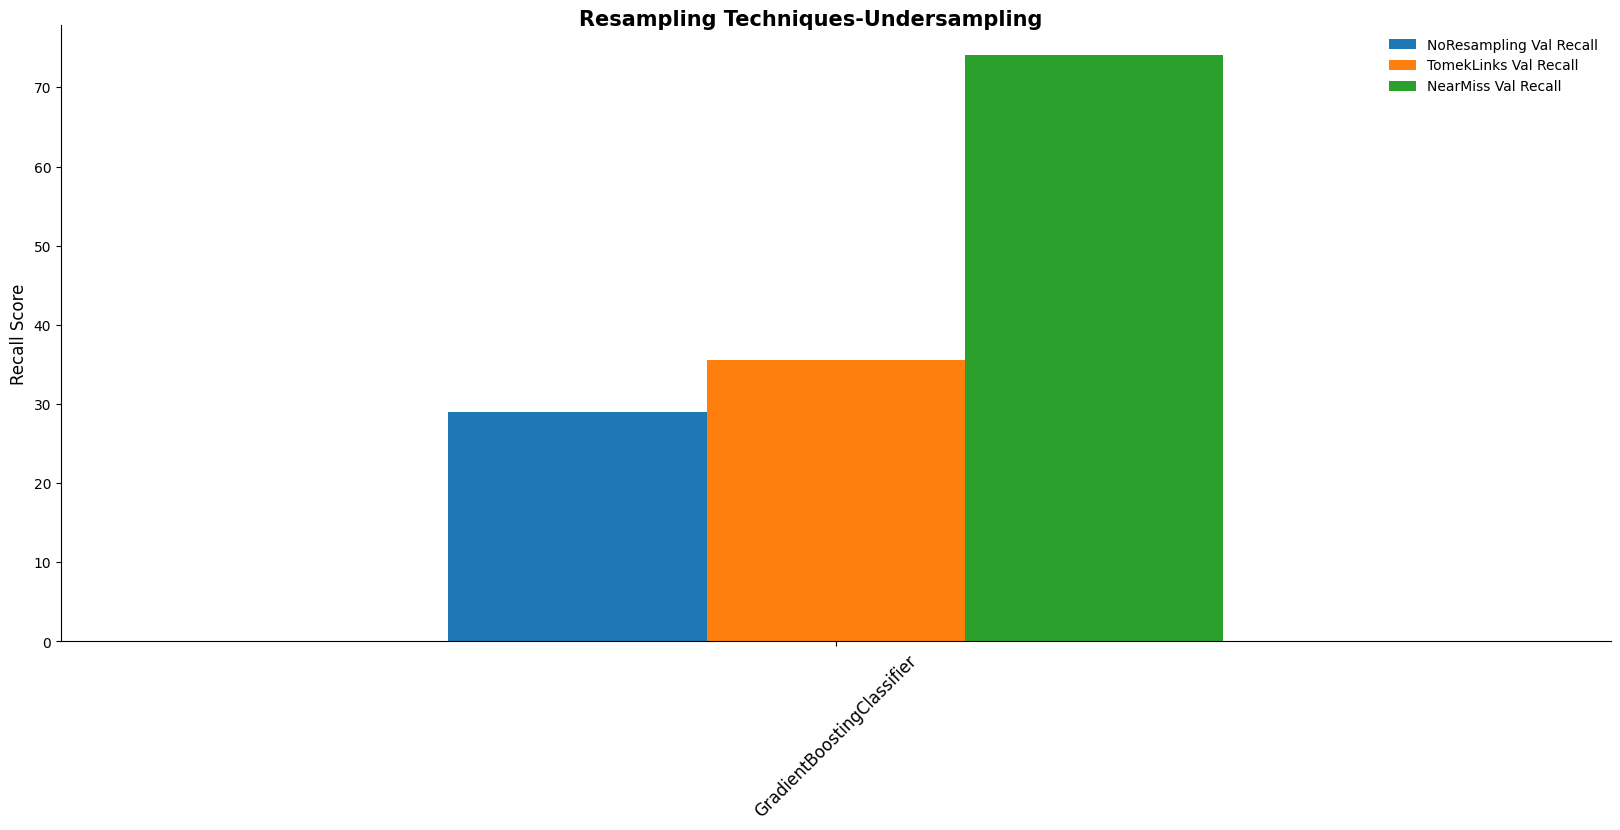

In [19]:
fig, ax = plt.subplots(figsize=(20, 8))
ps_under.plot.bar(ax=ax)
ax.set_ylabel('Recall Score', fontsize=12)
for spine in ['right', 'top']:
        ax.spines[spine].set_visible(False)
ax.legend(edgecolor='white')
fig.suptitle("Resampling Techniques-Undersampling", size=15, y=0.9, weight='bold')
plt.xticks(rotation=45, fontsize=12)
plt.show()

In [20]:
# Accuracy
ps_under_acc = pd.DataFrame(index=models_dict.keys())
ps_under_acc['NoResampling Val Accuracy'] = auto_run[0]['Val Accuracy']
ps_under_acc['TomekLinks Val Accuracy'] = outputs_u[0]['Val Accuracy']
ps_under_acc['NearMiss Val Accuracy'] = outputs_u[1]['Val Accuracy']
ps_under_acc

,NoResampling Val Accuracy,TomekLinks Val Accuracy,NearMiss Val Accuracy
GradientBoostingClassifier,85.72,85.81,38.97


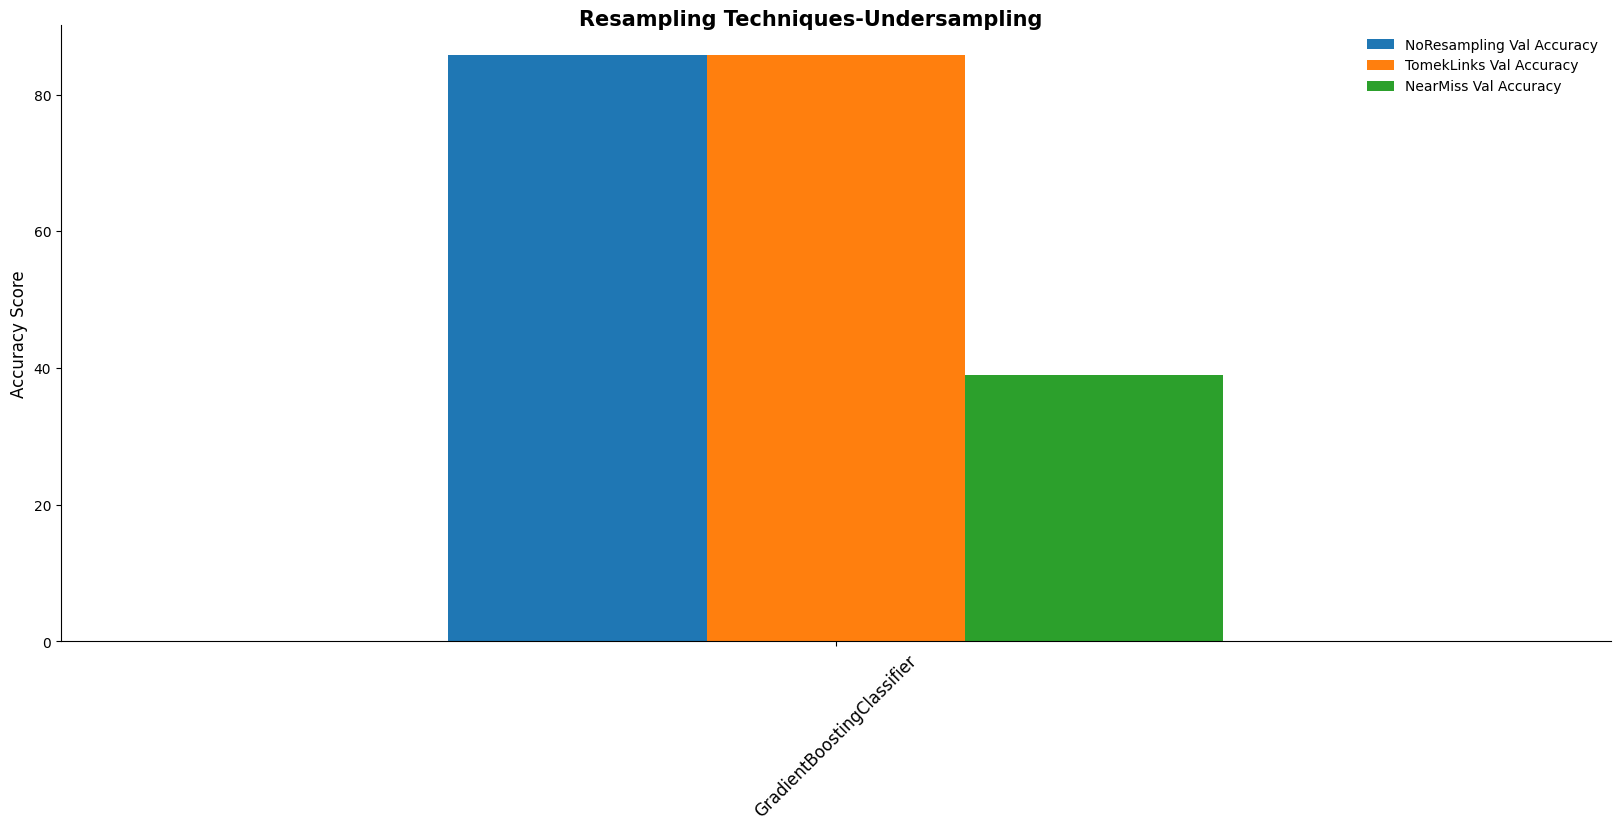

In [21]:
fig, ax = plt.subplots(figsize=(20, 8))
ps_under_acc.plot.bar(ax=ax)
ax.set_ylabel('Accuracy Score', fontsize=12)
for spine in ['right', 'top']:
        ax.spines[spine].set_visible(False)
ax.legend(edgecolor='white')
fig.suptitle("Resampling Techniques-Undersampling", size=15, y=0.9, weight='bold')
plt.xticks(rotation=45, fontsize=12)
plt.show()

# Oversampling

## SMOTE and ADASYN

In [22]:
res_list = [('SMOTE', SMOTE()),
            ('ADASYN', ADASYN())]

outputs = []
for title, res in res_list:
    print((title).center(120, "-"))
    var = auto_ml(X_train, y_train, models_dict, 
                  cv=StratifiedKFold(n_splits=5), res_t=res)
    outputs.append(var[0])
    display(var[1])

---------------------------------------------------------SMOTE----------------------------------------------------------


  0%|          | 0/1 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Resampling done in 0.015249967575073242
Resampling done in 0.0022962093353271484
Resampling done in 0.0020940303802490234
Resampling done in 0.002577066421508789
Resampling done in 0.009498834609985352


,Run Time,Train Accuracy,Train F1 Score,Train Precision,Train Recall,Val Accuracy,Val F1 Score,Val Precision,Val Recall
GradientBoostingClassifier,0.102647,92.21%,92.05%,94.03%,90.15%,82.22%,42.05%,44.10%,40.37%


---------------------------------------------------------ADASYN---------------------------------------------------------


  0%|          | 0/1 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Resampling done in 0.014648914337158203
Resampling done in 0.004271030426025391
Resampling done in 0.004269123077392578
Resampling done in 0.009392023086547852
Resampling done in 0.006342887878417969


,Run Time,Train Accuracy,Train F1 Score,Train Precision,Train Recall,Val Accuracy,Val F1 Score,Val Precision,Val Recall
GradientBoostingClassifier,0.101295,91.97%,91.58%,93.80%,89.47%,82.51%,41.99%,44.96%,39.77%


In [23]:
# Accuracy
ps_over_acc = pd.DataFrame(index=models_dict.keys())
ps_over_acc['Baseline Val Accuracy'] = auto_run[0]['Val Accuracy']
ps_over_acc['SMOTE Val Accuracy'] = outputs[0]['Val Accuracy']
ps_over_acc['ADASYN Val Accuracy'] = outputs[1]['Val Accuracy']
ps_over_acc

,Baseline Val Accuracy,SMOTE Val Accuracy,ADASYN Val Accuracy
GradientBoostingClassifier,85.72,82.22,82.51


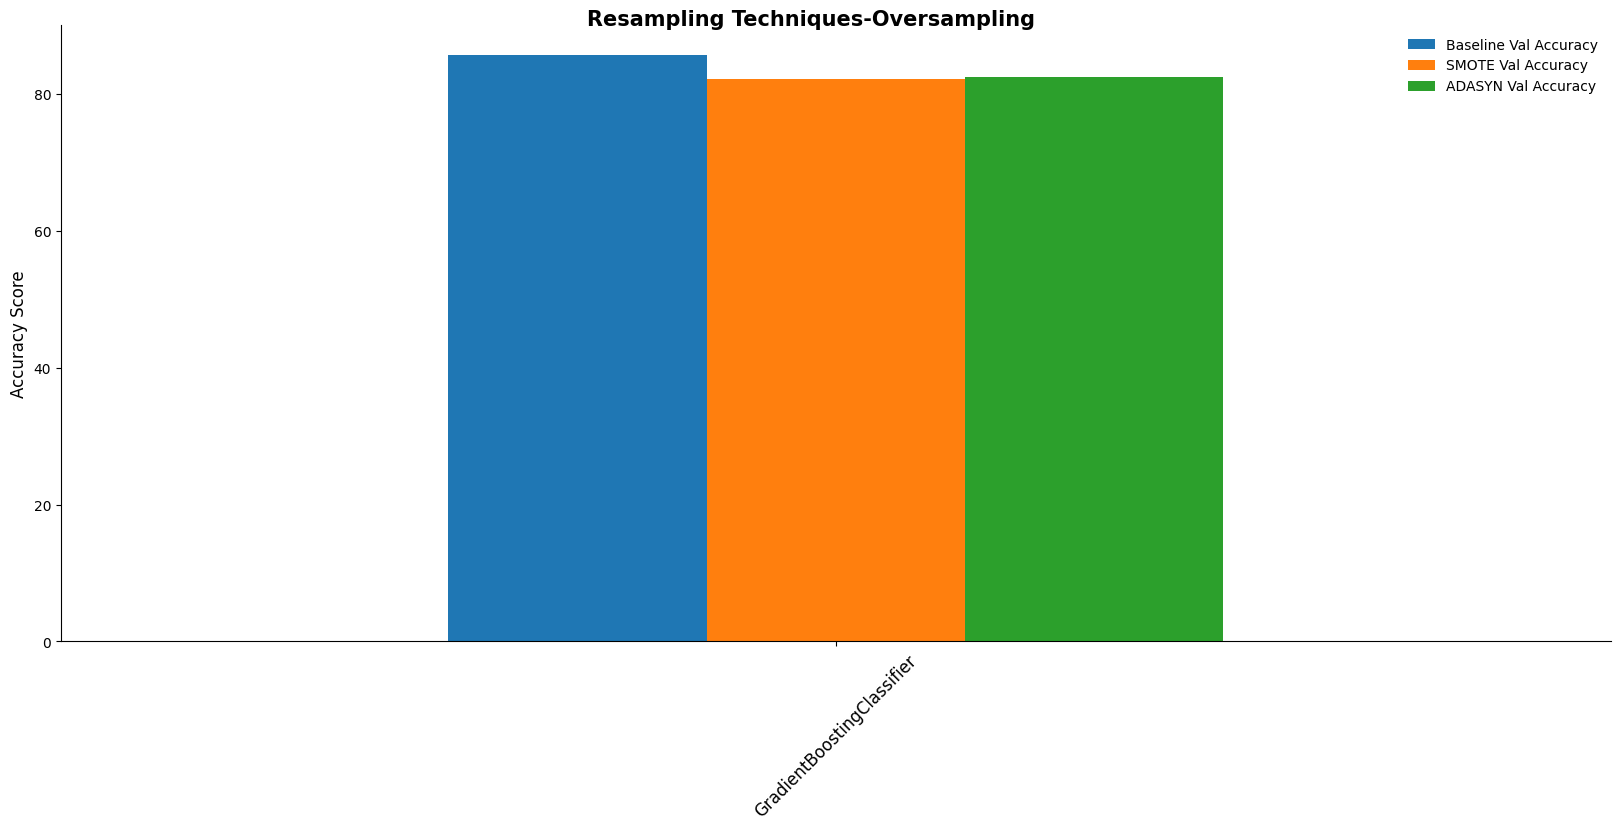

In [24]:
fig, ax = plt.subplots(figsize=(20, 8))
ps_over_acc.plot.bar(ax=ax)
ax.set_ylabel('Accuracy Score', fontsize=12)
for spine in ['right', 'top']:
        ax.spines[spine].set_visible(False)
ax.legend(edgecolor='white')
fig.suptitle("Resampling Techniques-Oversampling", size=15, y=0.9, weight='bold')
plt.xticks(rotation=45, fontsize=12)
plt.show()

In [25]:
# Recall
ps_over = pd.DataFrame(index=models_dict.keys())
ps_over['Baseline Val Recall'] = auto_run[0]['Val Recall']
ps_over['SMOTE Val Recall'] = outputs[0]['Val Recall']
ps_over['ADASYN Val Recall'] = outputs[1]['Val Recall']
ps_over

,Baseline Val Recall,SMOTE Val Recall,ADASYN Val Recall
GradientBoostingClassifier,28.95,40.37,39.77


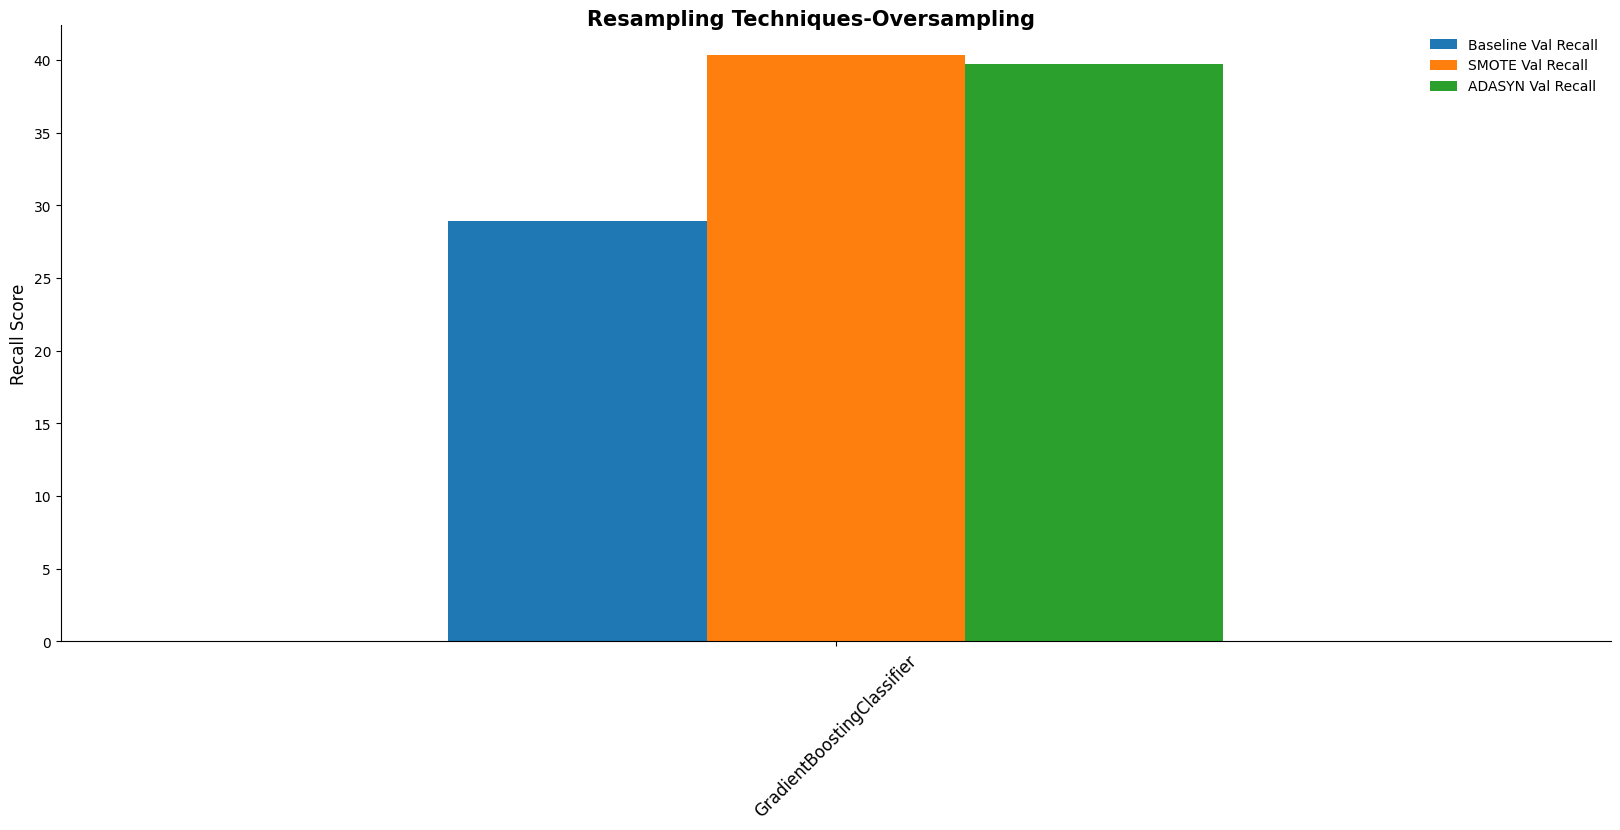

In [26]:
fig, ax = plt.subplots(figsize=(20, 8))
ps_over.plot.bar(ax=ax)
ax.set_ylabel('Recall Score', fontsize=12)
for spine in ['right', 'top']:
        ax.spines[spine].set_visible(False)
ax.legend(edgecolor='white')
fig.suptitle("Resampling Techniques-Oversampling", size=15, y=0.9, weight='bold')
plt.xticks(rotation=45, fontsize=12)
plt.show()

# SMOTEN

In [27]:
res_list = [('SMOTEN', SMOTEN())]

outputs = []
for title, res in res_list:
    print((title).center(120, "-"))
    var = auto_ml(X_train, y_train, models_dict, 
                  cv=StratifiedKFold(n_splits=5), res_t=res)
    outputs.append(var[0])
    display(var[1])

---------------------------------------------------------SMOTEN---------------------------------------------------------


  0%|          | 0/1 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Resampling done in 0.07946324348449707
Resampling done in 0.07646393775939941
Resampling done in 0.07355999946594238
Resampling done in 0.07230329513549805
Resampling done in 0.0735170841217041


,Run Time,Train Accuracy,Train F1 Score,Train Precision,Train Recall,Val Accuracy,Val F1 Score,Val Precision,Val Recall
GradientBoostingClassifier,0.09374,93.64%,93.53%,95.15%,91.98%,83.19%,40.13%,47.11%,35.58%


In [28]:
# Accuracy
ps_over_acc = pd.DataFrame(index=models_dict.keys())
ps_over_acc['Baseline Val Accuracy'] = auto_run[0]['Val Accuracy']
ps_over_acc['SMOTEN Val Accuracy'] = outputs[0]['Val Accuracy']
ps_over_acc

,Baseline Val Accuracy,SMOTEN Val Accuracy
GradientBoostingClassifier,85.72,83.19


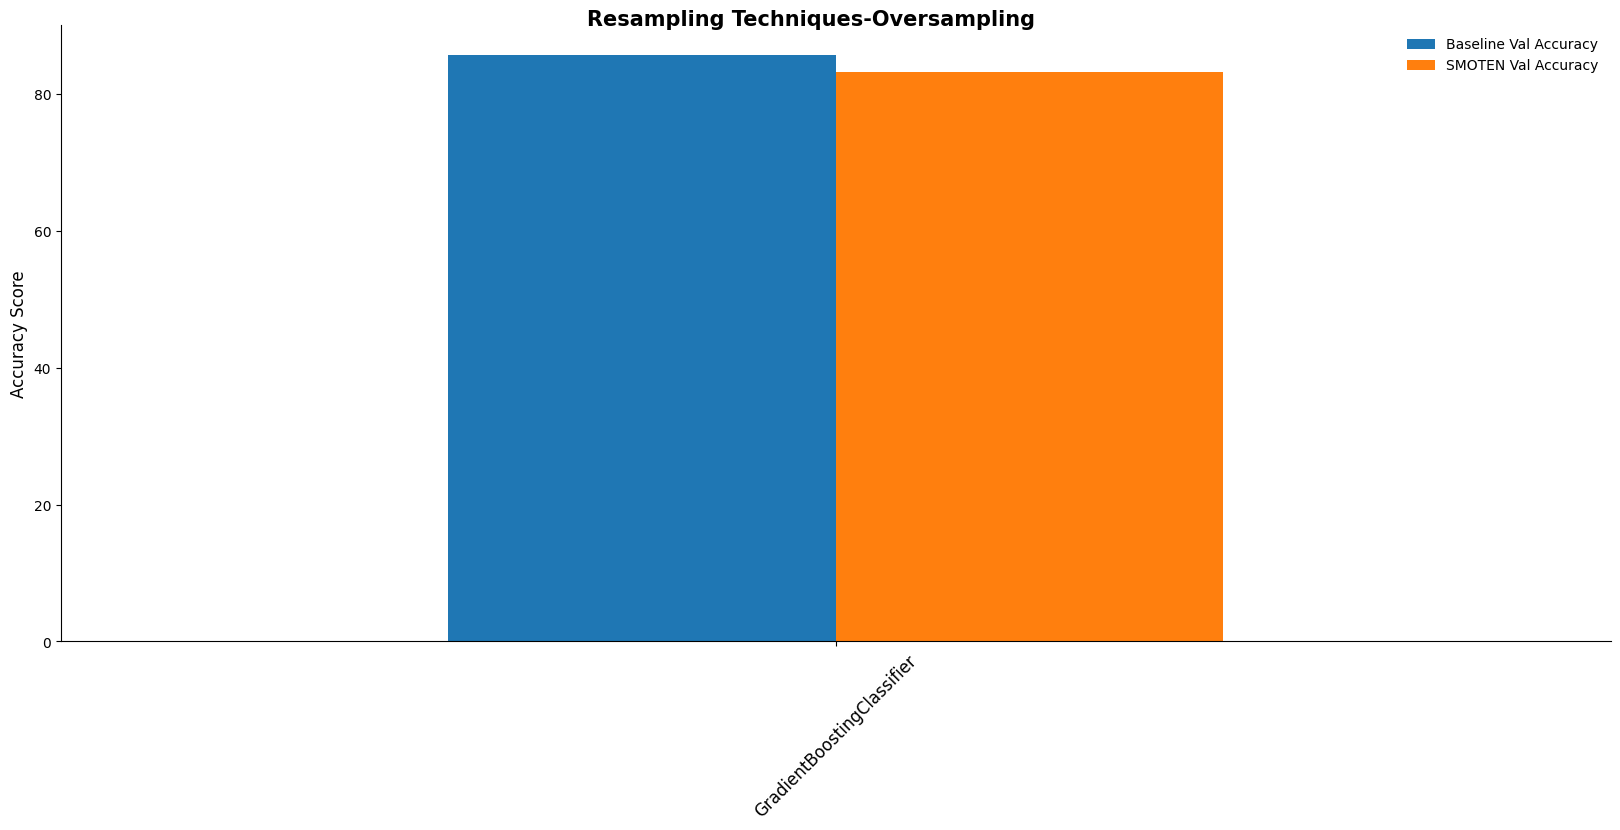

In [29]:
fig, ax = plt.subplots(figsize=(20, 8))
ps_over_acc.plot.bar(ax=ax)
ax.set_ylabel('Accuracy Score', fontsize=12)
for spine in ['right', 'top']:
        ax.spines[spine].set_visible(False)
ax.legend(edgecolor='white')
fig.suptitle("Resampling Techniques-Oversampling", size=15, y=0.9, weight='bold')
plt.xticks(rotation=45, fontsize=12)
plt.show()


In [30]:
# Recall
ps_over = pd.DataFrame(index=models_dict.keys())
ps_over['Baseline Val Recall'] = auto_run[0]['Val Recall']
ps_over['SMOTE Val Recall'] = outputs[0]['Val Recall']
ps_over

,Baseline Val Recall,SMOTE Val Recall
GradientBoostingClassifier,28.95,35.58


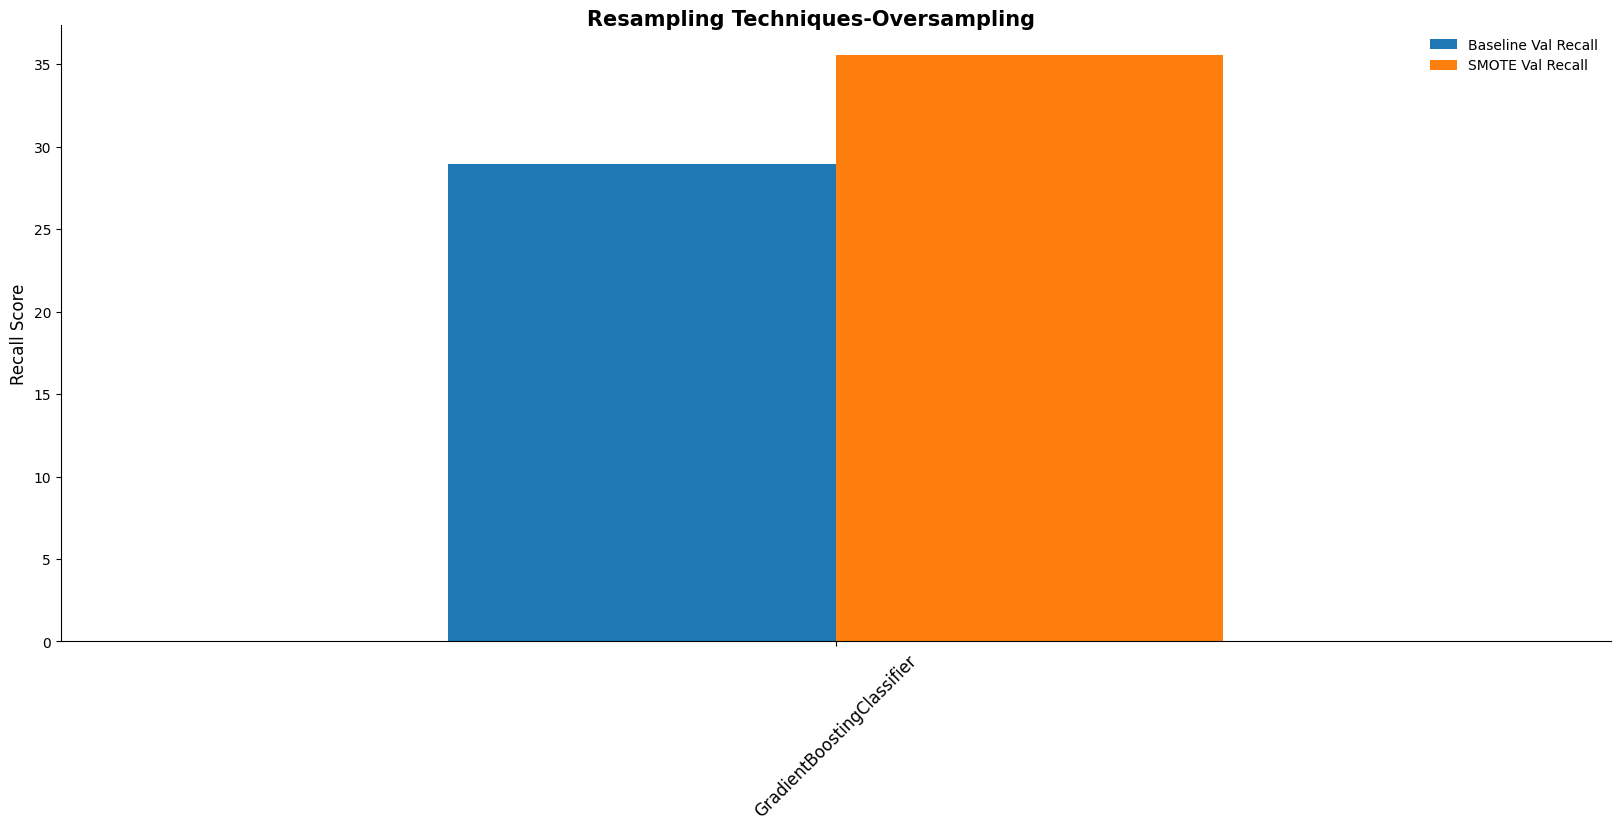

In [31]:
fig, ax = plt.subplots(figsize=(20, 8))
ps_over.plot.bar(ax=ax)
ax.set_ylabel('Recall Score', fontsize=12)
for spine in ['right', 'top']:
        ax.spines[spine].set_visible(False)
ax.legend(edgecolor='white')
fig.suptitle("Resampling Techniques-Oversampling", size=15, y=0.9, weight='bold')
plt.xticks(rotation=45, fontsize=12)
plt.show()

## Hypertuning

In [32]:
def train_gb(X, y, metric, res_t=None, hypertune=False, resample=False):
    params = {"n_estimators": [1, 10, 50, 100, 200],
              "learning_rate": [1, 0.5, 0.1, 0.01]
             }
    new_params = {'gradientboostingclassifier__' +
                  key: params[key] for key in params}

    skf = StratifiedKFold(n_splits=5)
    if resample is True:
        imba_pipeline = make_pipeline(MinMaxScaler(),
                                      res_t,
                                      GradientBoostingClassifier(random_state=143))
    else:
        imba_pipeline = make_pipeline(MinMaxScaler(),
                                      GradientBoostingClassifier(random_state=143))

    if hypertune is True:
        clf = GridSearchCV(imba_pipeline, param_grid=new_params,
                           cv=skf, scoring=metric, return_train_score=True,
                          verbose=10)
        start_time = time.time()
        clf.fit(X, y)
        run_time = (time.time() - start_time)
        model = clf.best_estimator_.fit(X, y)
        return ['Gradient Boosting Classifier', np.mean(clf.cv_results_['mean_train_score']),
                clf.best_score_, 'Best parameters = {0}'.format(
                    clf.best_params_),
                run_time, model]
    else:
        clf = imba_pipeline
        start_time = time.time()
        clf.fit(X, y)
        run_time = (time.time() - start_time)
        cv_scores = cross_validate(estimator=clf, X=X, y=y,
                                   scoring=metric, cv=skf, n_jobs=-1,
                                   return_train_score=True)

        return ['Gradient Boosting Classifier', np.mean(cv_scores['train_score']),
                np.mean(cv_scores['test_score']), run_time, clf]

# Random Undersampling

In [33]:
start_time_gb = time.time()
gb_us_rec = train_gb(X_train, y_train, 'recall', RandomUnderSampler(),
                       hypertune=True, resample=True)
end_time_gb = time.time()

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV 1/5; 1/20] START gradientboostingclassifier__learning_rate=1, gradientboostingclassifier__n_estimators=1
[CV 1/5; 1/20] END gradientboostingclassifier__learning_rate=1, gradientboostingclassifier__n_estimators=1;, score=(train=0.414, test=0.182) total time=   0.0s
[CV 2/5; 1/20] START gradientboostingclassifier__learning_rate=1, gradientboostingclassifier__n_estimators=1
[CV 2/5; 1/20] END gradientboostingclassifier__learning_rate=1, gradientboostingclassifier__n_estimators=1;, score=(train=0.541, test=0.545) total time=   0.0s
[CV 3/5; 1/20] START gradientboostingclassifier__learning_rate=1, gradientboostingclassifier__n_estimators=1
[CV 3/5; 1/20] END gradientboostingclassifier__learning_rate=1, gradientboostingclassifier__n_estimators=1;, score=(train=0.684, test=0.606) total time=   0.0s
[CV 4/5; 1/20] START gradientboostingclassifier__learning_rate=1, gradientboostingclassifier__n_estimators=1
[CV 4/5; 1/20] END gra

[CV 1/5; 7/20] END gradientboostingclassifier__learning_rate=0.5, gradientboostingclassifier__n_estimators=10;, score=(train=0.835, test=0.545) total time=   0.0s
[CV 2/5; 7/20] START gradientboostingclassifier__learning_rate=0.5, gradientboostingclassifier__n_estimators=10
[CV 2/5; 7/20] END gradientboostingclassifier__learning_rate=0.5, gradientboostingclassifier__n_estimators=10;, score=(train=0.827, test=0.727) total time=   0.0s
[CV 3/5; 7/20] START gradientboostingclassifier__learning_rate=0.5, gradientboostingclassifier__n_estimators=10
[CV 3/5; 7/20] END gradientboostingclassifier__learning_rate=0.5, gradientboostingclassifier__n_estimators=10;, score=(train=0.872, test=0.576) total time=   0.0s
[CV 4/5; 7/20] START gradientboostingclassifier__learning_rate=0.5, gradientboostingclassifier__n_estimators=10
[CV 4/5; 7/20] END gradientboostingclassifier__learning_rate=0.5, gradientboostingclassifier__n_estimators=10;, score=(train=0.833, test=0.618) total time=   0.0s
[CV 5/5; 7/2

[CV 2/5; 13/20] END gradientboostingclassifier__learning_rate=0.1, gradientboostingclassifier__n_estimators=50;, score=(train=0.872, test=0.758) total time=   0.0s
[CV 3/5; 13/20] START gradientboostingclassifier__learning_rate=0.1, gradientboostingclassifier__n_estimators=50
[CV 3/5; 13/20] END gradientboostingclassifier__learning_rate=0.1, gradientboostingclassifier__n_estimators=50;, score=(train=0.910, test=0.667) total time=   0.0s
[CV 4/5; 13/20] START gradientboostingclassifier__learning_rate=0.1, gradientboostingclassifier__n_estimators=50
[CV 4/5; 13/20] END gradientboostingclassifier__learning_rate=0.1, gradientboostingclassifier__n_estimators=50;, score=(train=0.879, test=0.647) total time=   0.0s
[CV 5/5; 13/20] START gradientboostingclassifier__learning_rate=0.1, gradientboostingclassifier__n_estimators=50
[CV 5/5; 13/20] END gradientboostingclassifier__learning_rate=0.1, gradientboostingclassifier__n_estimators=50;, score=(train=0.842, test=0.606) total time=   0.0s
[CV 1

[CV 2/5; 20/20] END gradientboostingclassifier__learning_rate=0.01, gradientboostingclassifier__n_estimators=200;, score=(train=0.782, test=0.606) total time=   0.1s
[CV 3/5; 20/20] START gradientboostingclassifier__learning_rate=0.01, gradientboostingclassifier__n_estimators=200
[CV 3/5; 20/20] END gradientboostingclassifier__learning_rate=0.01, gradientboostingclassifier__n_estimators=200;, score=(train=0.789, test=0.606) total time=   0.1s
[CV 4/5; 20/20] START gradientboostingclassifier__learning_rate=0.01, gradientboostingclassifier__n_estimators=200
[CV 4/5; 20/20] END gradientboostingclassifier__learning_rate=0.01, gradientboostingclassifier__n_estimators=200;, score=(train=0.803, test=0.676) total time=   0.1s
[CV 5/5; 20/20] START gradientboostingclassifier__learning_rate=0.01, gradientboostingclassifier__n_estimators=200
[CV 5/5; 20/20] END gradientboostingclassifier__learning_rate=0.01, gradientboostingclassifier__n_estimators=200;, score=(train=0.752, test=0.636) total time

In [34]:
gb_us_rec

['Gradient Boosting Classifier',
 0.8251520847573477,
 0.6985739750445633,
 "Best parameters = {'gradientboostingclassifier__learning_rate': 1, 'gradientboostingclassifier__n_estimators': 100}",
 2.4264960289001465,
 Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                 ('randomundersampler', RandomUnderSampler()),
                 ('gradientboostingclassifier',
                  GradientBoostingClassifier(learning_rate=1,
                                             random_state=143))])]

In [35]:
start_time_gb1 = time.time()
gb_us_acc = train_gb(X_train, y_train, 'accuracy', RandomUnderSampler(),
                      hypertune=True, resample=True)
end_time_gb1 = time.time()

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV 1/5; 1/20] START gradientboostingclassifier__learning_rate=1, gradientboostingclassifier__n_estimators=1
[CV 1/5; 1/20] END gradientboostingclassifier__learning_rate=1, gradientboostingclassifier__n_estimators=1;, score=(train=0.813, test=0.782) total time=   0.0s
[CV 2/5; 1/20] START gradientboostingclassifier__learning_rate=1, gradientboostingclassifier__n_estimators=1
[CV 2/5; 1/20] END gradientboostingclassifier__learning_rate=1, gradientboostingclassifier__n_estimators=1;, score=(train=0.790, test=0.772) total time=   0.0s
[CV 3/5; 1/20] START gradientboostingclassifier__learning_rate=1, gradientboostingclassifier__n_estimators=1
[CV 3/5; 1/20] END gradientboostingclassifier__learning_rate=1, gradientboostingclassifier__n_estimators=1;, score=(train=0.649, test=0.641) total time=   0.0s
[CV 4/5; 1/20] START gradientboostingclassifier__learning_rate=1, gradientboostingclassifier__n_estimators=1
[CV 4/5; 1/20] END gra

[CV 3/5; 8/20] END gradientboostingclassifier__learning_rate=0.5, gradientboostingclassifier__n_estimators=50;, score=(train=0.779, test=0.655) total time=   0.0s
[CV 4/5; 8/20] START gradientboostingclassifier__learning_rate=0.5, gradientboostingclassifier__n_estimators=50
[CV 4/5; 8/20] END gradientboostingclassifier__learning_rate=0.5, gradientboostingclassifier__n_estimators=50;, score=(train=0.752, test=0.626) total time=   0.0s
[CV 5/5; 8/20] START gradientboostingclassifier__learning_rate=0.5, gradientboostingclassifier__n_estimators=50
[CV 5/5; 8/20] END gradientboostingclassifier__learning_rate=0.5, gradientboostingclassifier__n_estimators=50;, score=(train=0.800, test=0.722) total time=   0.0s
[CV 1/5; 9/20] START gradientboostingclassifier__learning_rate=0.5, gradientboostingclassifier__n_estimators=100
[CV 1/5; 9/20] END gradientboostingclassifier__learning_rate=0.5, gradientboostingclassifier__n_estimators=100;, score=(train=0.768, test=0.665) total time=   0.0s
[CV 2/5; 9

[CV 3/5; 14/20] END gradientboostingclassifier__learning_rate=0.1, gradientboostingclassifier__n_estimators=100;, score=(train=0.790, test=0.680) total time=   0.0s
[CV 4/5; 14/20] START gradientboostingclassifier__learning_rate=0.1, gradientboostingclassifier__n_estimators=100
[CV 4/5; 14/20] END gradientboostingclassifier__learning_rate=0.1, gradientboostingclassifier__n_estimators=100;, score=(train=0.776, test=0.675) total time=   0.0s
[CV 5/5; 14/20] START gradientboostingclassifier__learning_rate=0.1, gradientboostingclassifier__n_estimators=100
[CV 5/5; 14/20] END gradientboostingclassifier__learning_rate=0.1, gradientboostingclassifier__n_estimators=100;, score=(train=0.775, test=0.698) total time=   0.0s
[CV 1/5; 15/20] START gradientboostingclassifier__learning_rate=0.1, gradientboostingclassifier__n_estimators=200
[CV 1/5; 15/20] END gradientboostingclassifier__learning_rate=0.1, gradientboostingclassifier__n_estimators=200;, score=(train=0.806, test=0.723) total time=   0.1

[CV 5/5; 20/20] END gradientboostingclassifier__learning_rate=0.01, gradientboostingclassifier__n_estimators=200;, score=(train=0.786, test=0.771) total time=   0.1s


In [36]:
gb_us_acc

['Gradient Boosting Classifier',
 0.7612590392714318,
 0.7492919725313758,
 "Best parameters = {'gradientboostingclassifier__learning_rate': 0.01, 'gradientboostingclassifier__n_estimators': 200}",
 2.4034180641174316,
 Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                 ('randomundersampler', RandomUnderSampler()),
                 ('gradientboostingclassifier',
                  GradientBoostingClassifier(learning_rate=0.01,
                                             n_estimators=200,
                                             random_state=143))])]

In [37]:
cols = ['', 'Train Accuracy', 'Val Accuracy',
        'Train Recall', 'Val Recall']
hyper = pd.DataFrame(columns=cols)
hyper.loc[0] = [gb_us_rec[0],
                np.round(gb_us_acc[1]*100, 6),
                np.round(gb_us_acc[2]*100, 6),
                np.round(gb_us_rec[1]*100, 6),
                np.round(gb_us_rec[2]*100, 6)]
hyper2 = pd.DataFrame(columns=cols)
hyper2.loc[0] = [gb_us_rec[0],
                 '{:.2f}%'.format(np.round(gb_us_acc[1]*100, 2)),
                 '{:.2f}%'.format(np.round(gb_us_acc[2]*100, 2)),
                 '{:.2f}%'.format(np.round(gb_us_rec[1]*100, 2)),
                 '{:.2f}%'.format(np.round(gb_us_rec[2]*100, 2))]
hyper2.style.hide_index()

,Train Accuracy,Val Accuracy,Train Recall,Val Recall
Gradient Boosting Classifier,76.13%,74.93%,82.52%,69.86%


In [38]:
rh = gb_us_rec[-1]
rh.fit(X_train, y_train)
y_preds = rh.predict(X_test)
rh_holdout_score = recall_score(y_test, y_preds)

In [39]:
base_var = train_gb(X_train, y_train, 'recall', hypertune=False, resample=False)

base_model = base_var[-1]
base_model.fit(X_train, y_train)
y_preds = base_model.predict(X_test)
holdout_score = recall_score(y_test, y_preds)

In [40]:
cols = ['Method', 'Train Recall', 'Val Recall', 'Holdout Recall']
summary = pd.DataFrame(columns=cols)
summary.loc[0] = ['No Resampling',
                 '{:.2f}%'.format(np.round(base_var[1]*100, 2)),
                 '{:.2f}%'.format(np.round(base_var[2]*100, 2)),
                 '{:.2f}%'.format(np.round(holdout_score*100, 2))]
summary.loc[3] = ['Resampling x Hypertune',
                 '{:.2f}%'.format(np.round(gb_us_rec[1]*100, 2)),
                 '{:.2f}%'.format(np.round(gb_us_rec[2]*100, 2)),
                 '{:.2f}%'.format(np.round(rh_holdout_score*100, 2))]
summary.style.hide_index()

Method,Train Recall,Val Recall,Holdout Recall
No Resampling,56.02%,28.95%,26.76%
Resampling x Hypertune,82.52%,69.86%,54.93%


# NearMiss

In [41]:
start_time_gb = time.time()
gb_tk_rec = train_gb(X_train, y_train, 'recall', NearMiss(),
                       hypertune=True, resample=True)
end_time_gb = time.time()

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV 1/5; 1/20] START gradientboostingclassifier__learning_rate=1, gradientboostingclassifier__n_estimators=1
[CV 1/5; 1/20] END gradientboostingclassifier__learning_rate=1, gradientboostingclassifier__n_estimators=1;, score=(train=0.692, test=0.515) total time=   0.0s
[CV 2/5; 1/20] START gradientboostingclassifier__learning_rate=1, gradientboostingclassifier__n_estimators=1
[CV 2/5; 1/20] END gradientboostingclassifier__learning_rate=1, gradientboostingclassifier__n_estimators=1;, score=(train=0.699, test=0.758) total time=   0.0s
[CV 3/5; 1/20] START gradientboostingclassifier__learning_rate=1, gradientboostingclassifier__n_estimators=1
[CV 3/5; 1/20] END gradientboostingclassifier__learning_rate=1, gradientboostingclassifier__n_estimators=1;, score=(train=0.737, test=0.636) total time=   0.0s
[CV 4/5; 1/20] START gradientboostingclassifier__learning_rate=1, gradientboostingclassifier__n_estimators=1
[CV 4/5; 1/20] END gra

[CV 2/5; 9/20] END gradientboostingclassifier__learning_rate=0.5, gradientboostingclassifier__n_estimators=100;, score=(train=1.000, test=0.788) total time=   0.0s
[CV 3/5; 9/20] START gradientboostingclassifier__learning_rate=0.5, gradientboostingclassifier__n_estimators=100
[CV 3/5; 9/20] END gradientboostingclassifier__learning_rate=0.5, gradientboostingclassifier__n_estimators=100;, score=(train=1.000, test=0.697) total time=   0.0s
[CV 4/5; 9/20] START gradientboostingclassifier__learning_rate=0.5, gradientboostingclassifier__n_estimators=100
[CV 4/5; 9/20] END gradientboostingclassifier__learning_rate=0.5, gradientboostingclassifier__n_estimators=100;, score=(train=1.000, test=0.706) total time=   0.0s
[CV 5/5; 9/20] START gradientboostingclassifier__learning_rate=0.5, gradientboostingclassifier__n_estimators=100
[CV 5/5; 9/20] END gradientboostingclassifier__learning_rate=0.5, gradientboostingclassifier__n_estimators=100;, score=(train=1.000, test=0.788) total time=   0.0s
[CV 1

[CV 2/5; 15/20] END gradientboostingclassifier__learning_rate=0.1, gradientboostingclassifier__n_estimators=200;, score=(train=0.970, test=0.848) total time=   0.1s
[CV 3/5; 15/20] START gradientboostingclassifier__learning_rate=0.1, gradientboostingclassifier__n_estimators=200
[CV 3/5; 15/20] END gradientboostingclassifier__learning_rate=0.1, gradientboostingclassifier__n_estimators=200;, score=(train=0.962, test=0.606) total time=   0.1s
[CV 4/5; 15/20] START gradientboostingclassifier__learning_rate=0.1, gradientboostingclassifier__n_estimators=200
[CV 4/5; 15/20] END gradientboostingclassifier__learning_rate=0.1, gradientboostingclassifier__n_estimators=200;, score=(train=1.000, test=0.735) total time=   0.1s
[CV 5/5; 15/20] START gradientboostingclassifier__learning_rate=0.1, gradientboostingclassifier__n_estimators=200
[CV 5/5; 15/20] END gradientboostingclassifier__learning_rate=0.1, gradientboostingclassifier__n_estimators=200;, score=(train=0.977, test=0.818) total time=   0.1

In [42]:
gb_tk_rec

['Gradient Boosting Classifier',
 0.8420272271588061,
 0.7532976827094474,
 "Best parameters = {'gradientboostingclassifier__learning_rate': 1, 'gradientboostingclassifier__n_estimators': 100}",
 2.706716775894165,
 Pipeline(steps=[('minmaxscaler', MinMaxScaler()), ('nearmiss', NearMiss()),
                 ('gradientboostingclassifier',
                  GradientBoostingClassifier(learning_rate=1,
                                             random_state=143))])]

In [43]:
start_time_gb1 = time.time()
gb_tk_acc = train_gb(X_train, y_train, 'accuracy', NearMiss(),
                      hypertune=True, resample=True)
end_time_gb1 = time.time()

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV 1/5; 1/20] START gradientboostingclassifier__learning_rate=1, gradientboostingclassifier__n_estimators=1
[CV 1/5; 1/20] END gradientboostingclassifier__learning_rate=1, gradientboostingclassifier__n_estimators=1;, score=(train=0.564, test=0.515) total time=   0.0s
[CV 2/5; 1/20] START gradientboostingclassifier__learning_rate=1, gradientboostingclassifier__n_estimators=1
[CV 2/5; 1/20] END gradientboostingclassifier__learning_rate=1, gradientboostingclassifier__n_estimators=1;, score=(train=0.508, test=0.524) total time=   0.0s
[CV 3/5; 1/20] START gradientboostingclassifier__learning_rate=1, gradientboostingclassifier__n_estimators=1
[CV 3/5; 1/20] END gradientboostingclassifier__learning_rate=1, gradientboostingclassifier__n_estimators=1;, score=(train=0.502, test=0.481) total time=   0.0s
[CV 4/5; 1/20] START gradientboostingclassifier__learning_rate=1, gradientboostingclassifier__n_estimators=1
[CV 4/5; 1/20] END gra

[CV 2/5; 9/20] END gradientboostingclassifier__learning_rate=0.5, gradientboostingclassifier__n_estimators=100;, score=(train=0.570, test=0.481) total time=   0.0s
[CV 3/5; 9/20] START gradientboostingclassifier__learning_rate=0.5, gradientboostingclassifier__n_estimators=100
[CV 3/5; 9/20] END gradientboostingclassifier__learning_rate=0.5, gradientboostingclassifier__n_estimators=100;, score=(train=0.515, test=0.476) total time=   0.0s
[CV 4/5; 9/20] START gradientboostingclassifier__learning_rate=0.5, gradientboostingclassifier__n_estimators=100
[CV 4/5; 9/20] END gradientboostingclassifier__learning_rate=0.5, gradientboostingclassifier__n_estimators=100;, score=(train=0.522, test=0.442) total time=   0.0s
[CV 5/5; 9/20] START gradientboostingclassifier__learning_rate=0.5, gradientboostingclassifier__n_estimators=100
[CV 5/5; 9/20] END gradientboostingclassifier__learning_rate=0.5, gradientboostingclassifier__n_estimators=100;, score=(train=0.541, test=0.498) total time=   0.0s
[CV 1

[CV 2/5; 15/20] END gradientboostingclassifier__learning_rate=0.1, gradientboostingclassifier__n_estimators=200;, score=(train=0.554, test=0.519) total time=   0.1s
[CV 3/5; 15/20] START gradientboostingclassifier__learning_rate=0.1, gradientboostingclassifier__n_estimators=200
[CV 3/5; 15/20] END gradientboostingclassifier__learning_rate=0.1, gradientboostingclassifier__n_estimators=200;, score=(train=0.516, test=0.466) total time=   0.1s
[CV 4/5; 15/20] START gradientboostingclassifier__learning_rate=0.1, gradientboostingclassifier__n_estimators=200
[CV 4/5; 15/20] END gradientboostingclassifier__learning_rate=0.1, gradientboostingclassifier__n_estimators=200;, score=(train=0.504, test=0.413) total time=   0.1s
[CV 5/5; 15/20] START gradientboostingclassifier__learning_rate=0.1, gradientboostingclassifier__n_estimators=200
[CV 5/5; 15/20] END gradientboostingclassifier__learning_rate=0.1, gradientboostingclassifier__n_estimators=200;, score=(train=0.506, test=0.517) total time=   0.1

In [44]:
gb_tk_acc

['Gradient Boosting Classifier',
 0.5305671442390496,
 0.535586076249112,
 "Best parameters = {'gradientboostingclassifier__learning_rate': 1, 'gradientboostingclassifier__n_estimators': 1}",
 2.6167659759521484,
 Pipeline(steps=[('minmaxscaler', MinMaxScaler()), ('nearmiss', NearMiss()),
                 ('gradientboostingclassifier',
                  GradientBoostingClassifier(learning_rate=1, n_estimators=1,
                                             random_state=143))])]

In [45]:
cols = ['', 'Train Accuracy', 'Val Accuracy',
        'Train Recall', 'Val Recall']
hyper = pd.DataFrame(columns=cols)
hyper.loc[0] = [gb_tk_rec[0],
                np.round(gb_tk_acc[1]*100, 6),
                np.round(gb_tk_acc[2]*100, 6),
                np.round(gb_tk_rec[1]*100, 6),
                np.round(gb_tk_rec[2]*100, 6)]
hyper2 = pd.DataFrame(columns=cols)
hyper2.loc[0] = [gb_tk_rec[0],
                 '{:.2f}%'.format(np.round(gb_tk_acc[1]*100, 2)),
                 '{:.2f}%'.format(np.round(gb_tk_acc[2]*100, 2)),
                 '{:.2f}%'.format(np.round(gb_tk_rec[1]*100, 2)),
                 '{:.2f}%'.format(np.round(gb_tk_rec[2]*100, 2))]
hyper2.style.hide_index()

,Train Accuracy,Val Accuracy,Train Recall,Val Recall
Gradient Boosting Classifier,53.06%,53.56%,84.20%,75.33%


In [46]:
rh = gb_tk_rec[-1]
rh.fit(X_train, y_train)
y_preds = rh.predict(X_test)
rh_holdout_score = recall_score(y_test, y_preds)

In [47]:
base_var = train_gb(X_train, y_train, 'recall', hypertune=False, resample=False)

base_model = base_var[-1]
base_model.fit(X_train, y_train)
y_preds = base_model.predict(X_test)
holdout_score = recall_score(y_test, y_preds)

In [48]:
cols = ['Method', 'Train Recall', 'Val Recall', 'Holdout Recall']
summary = pd.DataFrame(columns=cols)
summary.loc[0] = ['No Resampling',
                 '{:.2f}%'.format(np.round(base_var[1]*100, 2)),
                 '{:.2f}%'.format(np.round(base_var[2]*100, 2)),
                 '{:.2f}%'.format(np.round(holdout_score*100, 2))]
summary.loc[3] = ['Resampling x Hypertune',
                 '{:.2f}%'.format(np.round(gb_tk_rec[1]*100, 2)),
                 '{:.2f}%'.format(np.round(gb_tk_rec[2]*100, 2)),
                 '{:.2f}%'.format(np.round(rh_holdout_score*100, 2))]
summary.style.hide_index()

Method,Train Recall,Val Recall,Holdout Recall
No Resampling,56.02%,28.95%,26.76%
Resampling x Hypertune,84.20%,75.33%,74.65%


In [49]:
model = rh['gradientboostingclassifier']
pickle.dump(model, open('model/model_gbm.pkl', 'wb'))

In [50]:
# training_data=pd.DataFrame(X_train.columns)
# training_data
# training_data.to_csv('model/training_cols.csv', index=False)

# Model Explainability

## Feature Importance

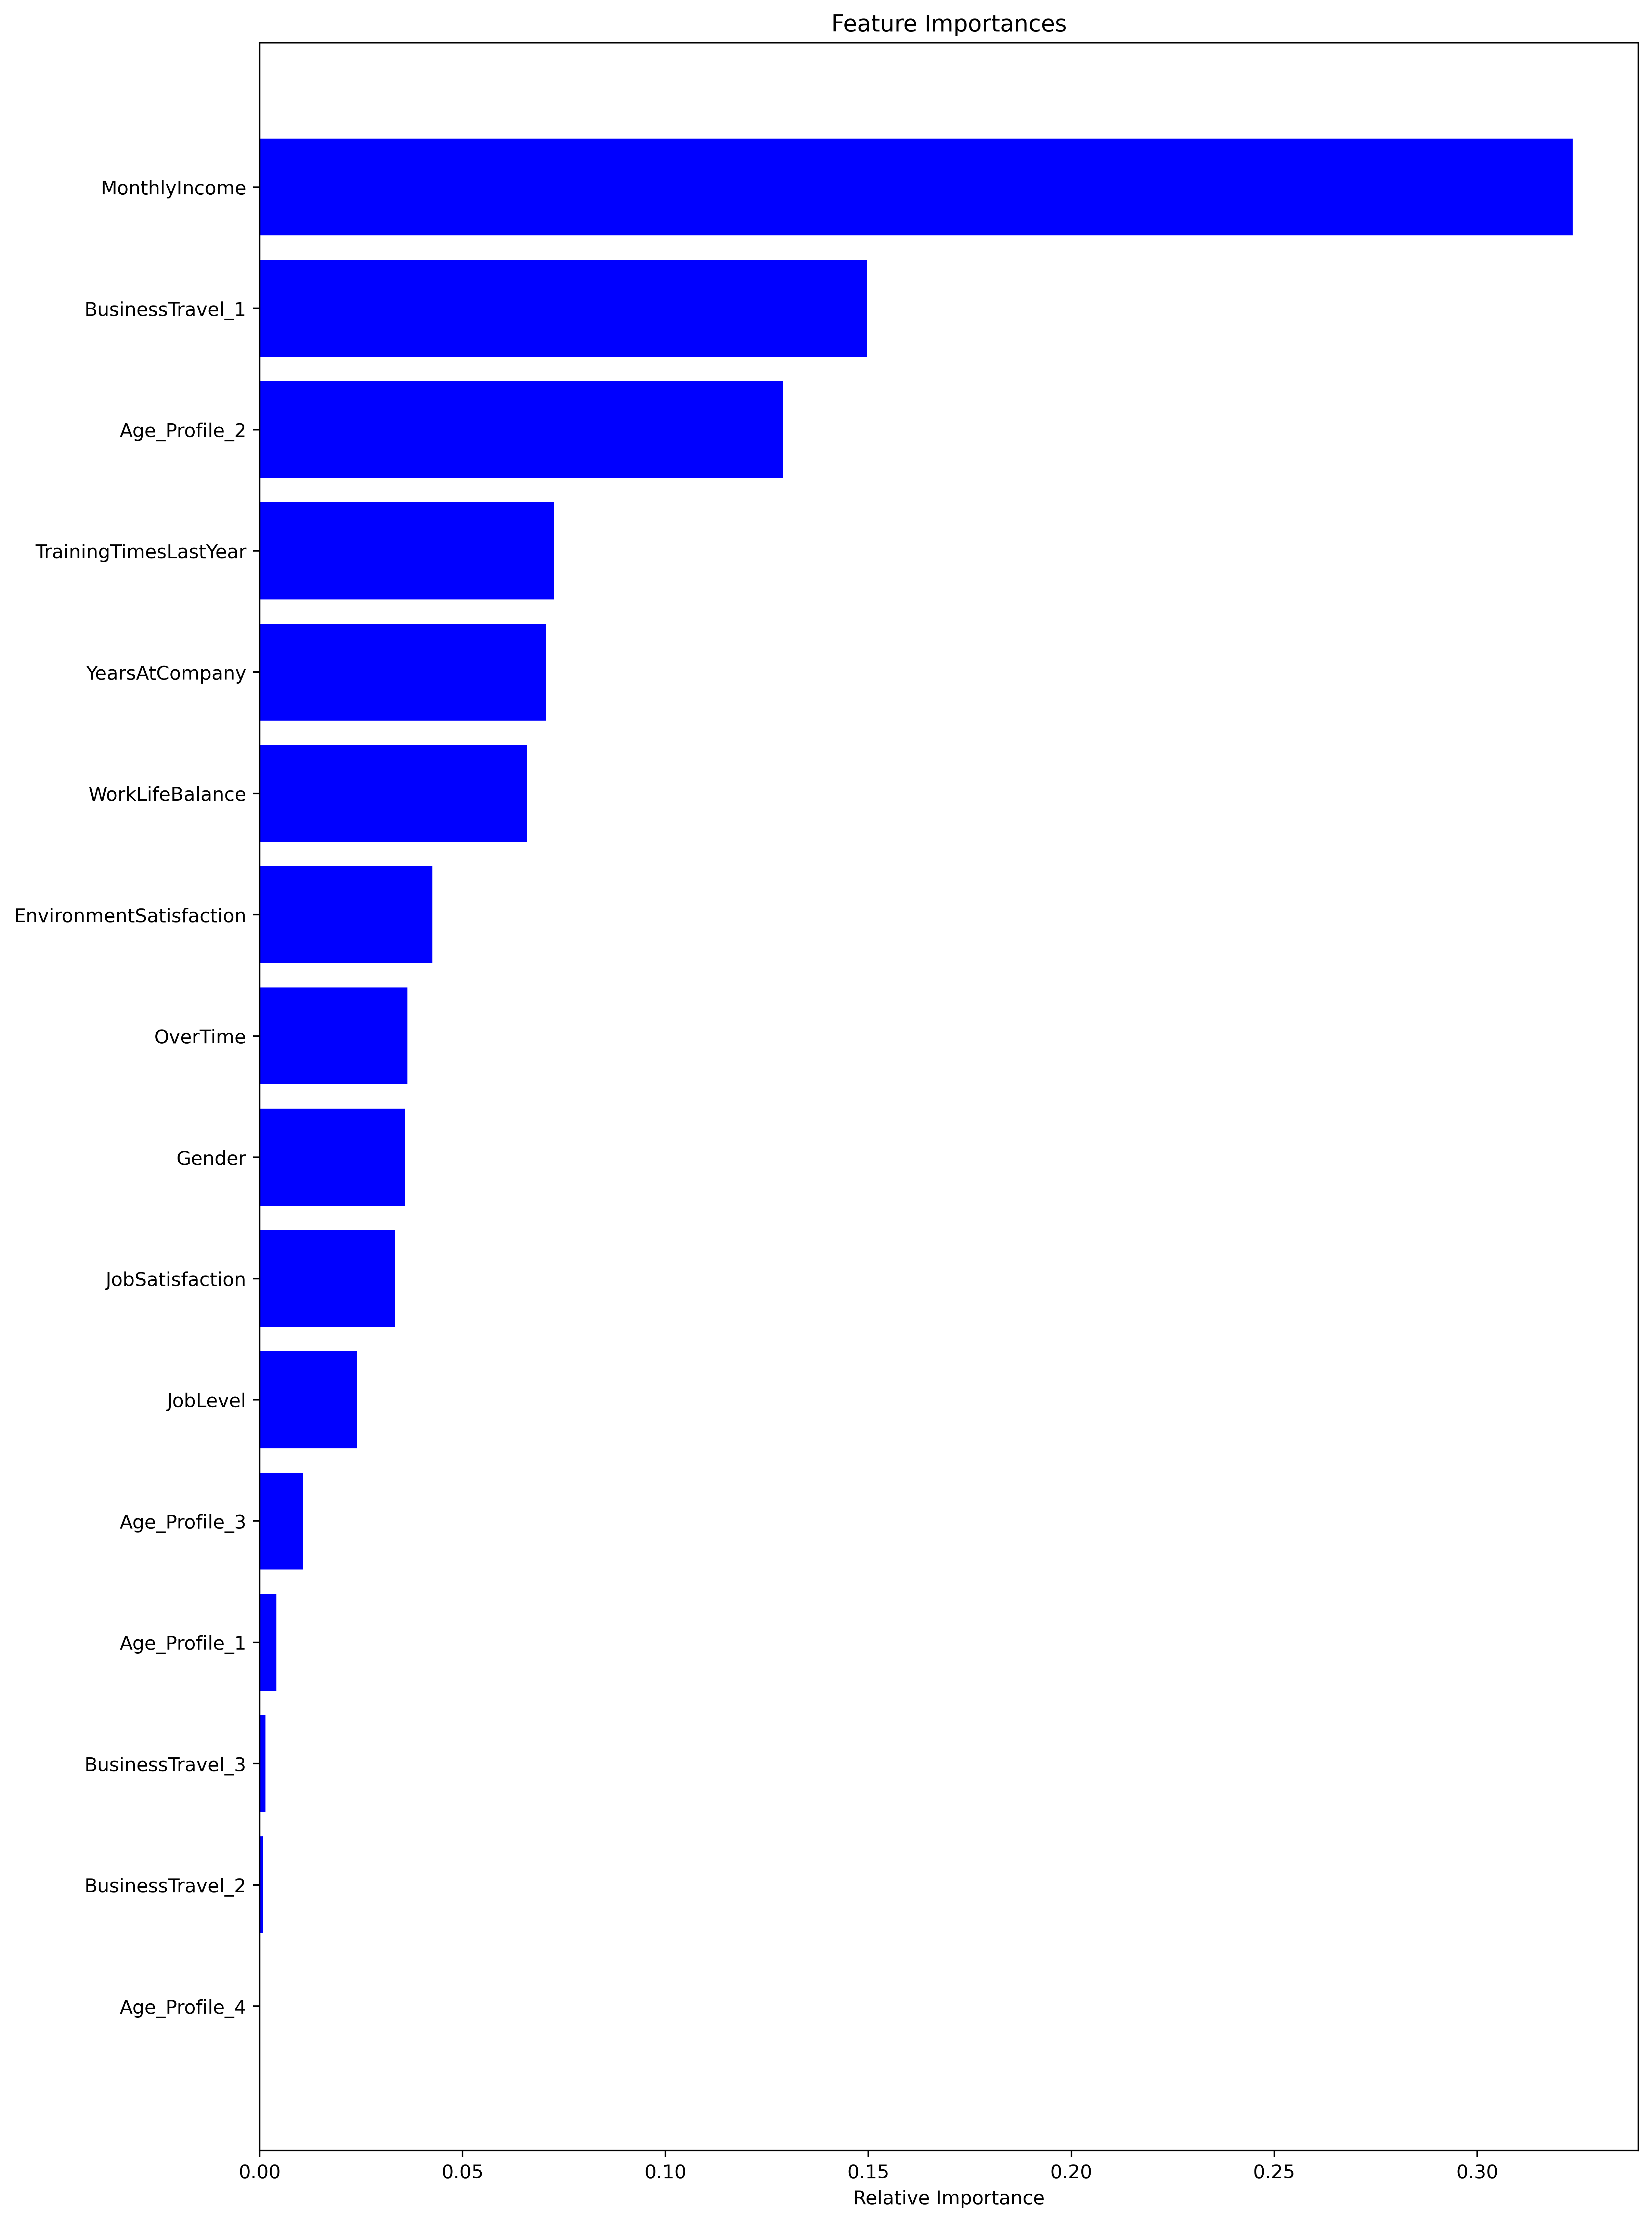

In [51]:
fig, ax = plt.subplots(figsize=(13, 20), dpi=400)

# print(model.feature_importances_)
importances = model.feature_importances_
indices = np.argsort(importances)
features = X_train.columns
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

# Beeswarm

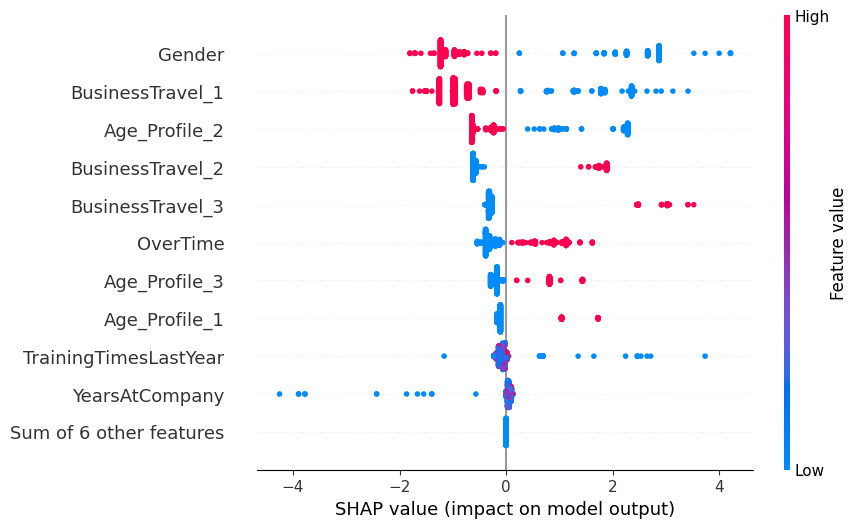

In [52]:
explainer1 = shap.Explainer(model, X_test)
shap_values = explainer1(X_test)

shap.plots.beeswarm(shap_values, max_display=11)